# Analysis of Density inside the Core

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import re,glob,os
from scipy import integrate
from numpy import pi as π
import dgutils
from pimcscripts import pimchelp
from collections import defaultdict
from scipy import interpolate
from dgutils import colors as colortools
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.transforms as mtransforms

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

# plot style
plot_style = {'aps':'../include/aps.mplstyle', 'notebook':'../include/notebook.mplstyle'}
plt.style.reload_library()
plt.style.use(plot_style['notebook'])

figsize = plt.rcParams['figure.figsize']

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ρ_col = [colors[0],colors[1],colors[-2]]
grey = '#4B4B4B'

import hg_utils
from hg_utils import lab as lab

## Simulation Parameters

In [4]:
ΔR = [0.0,2.0,3.0,4.0]
T = 2.0
w = 3.0
L = 100

## We load the merged (individual seeds) QMC data for the core density from the data directory

In [5]:
ρ_1d_seeds = {}

for cΔR in ΔR:
    dirName = f'{hg_utils.base_dir(cΔR,cylinder=True)}'

    # find the appropriate linedensity file and extract the value and headers
    fname = glob.glob(f'{dirName}/gce-linedensity-*')[0]
    headers = pimchelp.getHeadersFromFile(fname)
    x = np.array([float(cx) for cx in headers]) - L/2
    ρ_1d_seeds[lab(cΔR)] = np.loadtxt(fname)
    print(f'ΔR = {cΔR}:  {ρ_1d_seeds[lab(cΔR)].shape}')
    

ΔR = 0.0:  (200, 200)
ΔR = 2.0:  (100, 200)
ΔR = 3.0:  (205, 200)
ΔR = 4.0:  (151, 200)


## Exploit the mirror symmetry around $x=0$

In [6]:
start = int(len(x)/2)
end = len(x)

idx_pos = range(start,end-1)
idx_neg = range(start-1,0,-1)

for cΔR in ΔR:
    _ρ = np.copy(ρ_1d_seeds[lab(cΔR)])
    
    ρ_1d_seeds[lab(cΔR)][:,idx_neg] = 0.5*(_ρ[:,idx_pos] + _ρ[:,idx_neg])
    ρ_1d_seeds[lab(cΔR)][:,idx_pos] = 0.5*(_ρ[:,idx_pos] + _ρ[:,idx_neg])

## Compute the Average Density by integrating in the tails ($L-2w$)

In [7]:
x_mask_out_right = np.where(x > L/2-2*w)[0]

In [8]:
x[x_mask_out_right]

array([44.5, 45. , 45.5, 46. , 46.5, 47. , 47.5, 48. , 48.5, 49. , 49.5])

In [9]:
ρ_1d_seeds[lab(cΔR)][:,x_mask_out_right]

array([[0.24811873, 0.22325646, 0.22813494, ..., 0.23777504, 0.24349553,
        0.26466461],
       [0.16754352, 0.18880158, 0.25405812, ..., 0.20145968, 0.24729547,
        0.32083259],
       [0.28097016, 0.29881858, 0.26069187, ..., 0.27669255, 0.24843324,
        0.17895814],
       ...,
       [0.21606984, 0.20305782, 0.232058  , ..., 0.20293205, 0.23732069,
        0.2924372 ],
       [0.41663474, 0.31735534, 0.18576646, ..., 0.34051462, 0.20229335,
        0.11374025],
       [0.20740927, 0.24029032, 0.30292187, ..., 0.24457056, 0.31661727,
        0.39715121]])

In [43]:
0.0004923639710211857
(0.2501078352533328-0.0009762647096474287)/0.24933504404665563

0.9991839354000628

In [39]:
(x[x_mask_out_right[-1]] - x[x_mask_out_right[0]])

5.0

In [10]:
ρₒ_seeds = {}
x_mask_out_right = np.where(x > L/2-2*w)[0]

for cΔR in ΔR:
    ρₒ_seeds[lab(cΔR)] = integrate.simpson(ρ_1d_seeds[lab(cΔR)][:,x_mask_out_right],x=x[x_mask_out_right],axis=1)/(x[x_mask_out_right[-1]] - x[x_mask_out_right[0]])


0.24933504404665563 0.0009762647096474287


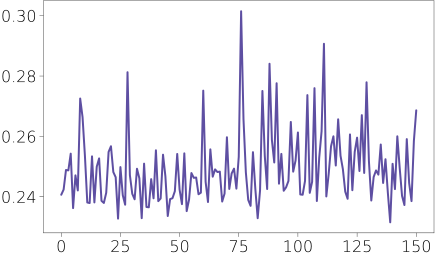

In [11]:
cΔR = 4.0
plt.plot(ρₒ_seeds[lab(cΔR)])
ave = np.average(ρₒ_seeds[lab(cΔR)])
std = np.std(ρₒ_seeds[lab(cΔR)])/np.sqrt(len(ρₒ_seeds[lab(cΔR)])-1)
print(ave,std)

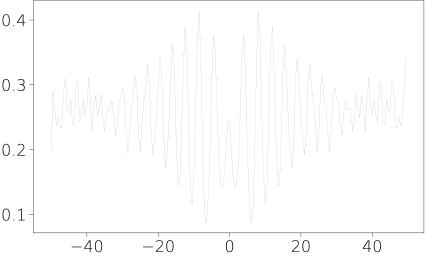

In [12]:
seed=117
plt.plot(x,ρ_1d_seeds[lab(cΔR)][seed,:], ls='-', lw=0.1)

In [15]:
cΔR = 4.0

for seed in range(ρ_1d_seeds[lab(cΔR)].shape[0]):
    plt.plot(x,ρ_1d_seeds[lab(cΔR)][seed,:], ls='None', marker='.')

In [ ]:
from scipy.signal import argrelmax,argrelmin

ρ_max_arg = defaultdict(list)
ρ_min_arg = defaultdict(list)

for cΔR in ΔR:
        
    # don't use mirror symmetry
    _x,_ρ,_Δρ = ρ_1d_qmc[lab(cΔR)].epdata(reduce_par) 
    
    # use mirror symmetry
    _x,_ρ,_Δρ = x,ρ̄_1d[lab(cΔR)],Δρ̄_1d[lab(cΔR)]
    
    idxs = list(range(x_mask_in[0]+1)) + list(range(x_mask_in[-1]+1,len(x)))
    max_arg = argrelmax(_ρ)[0]
    min_arg = argrelmin(_ρ)[0]
    
    x_cut_indices = x_mask_in
    
    ρ_max_arg[lab(cΔR)] = [carg for carg in max_arg if carg not in x_cut_indices]
    ρ_min_arg[lab(cΔR)] = [carg for carg in min_arg if carg not in x_cut_indices]

In [ ]:
ρₒ_ave = {}
Δρₒ_ave = {}

for cΔR in ΔR:

    tρₒ = []
    _x,_ρ,_Δρ =  ρ_1d_qmc[lab(cΔR)].epdata(reduce_par) 

    # first average max-to-max
    for num_peaks in range(1,5):
        neg_max_start,neg_max_end = ρ_max_arg[lab(cΔR)][1],ρ_max_arg[lab(cΔR)][num_peaks+1]
        pos_max_start,pos_max_end = ρ_max_arg[lab(cΔR)][-1-num_peaks],ρ_max_arg[lab(cΔR)][-1]
        tρₒ.append(np.average(
            np.hstack((_ρ[neg_max_start:neg_max_end+1],_ρ[pos_max_start:pos_max_end+1]))))
        
    # then min-to-min
    for num_troughs in range(1,5):
        neg_min_start,neg_min_end = ρ_min_arg[lab(cΔR)][1],ρ_min_arg[lab(cΔR)][num_troughs+1]
        pos_min_start,pos_min_end = ρ_min_arg[lab(cΔR)][-1-num_troughs],ρ_min_arg[lab(cΔR)][-1]
        tρₒ.append(np.average(
            np.hstack((_ρ[neg_min_start:neg_min_end+1],_ρ[pos_min_start:pos_min_end+1]))))
        
    ρₒ_ave[lab(cΔR)] = np.average(tρₒ)
    Δρₒ_ave[lab(cΔR)] = np.std(tρₒ)

with plt.style.context(plot_style['notebook']):
    figsize = plt.rcParams['figure.figsize']
    fig,ax = plt.subplots(nrows=1,ncols=1,sharex=True, sharey=True, figsize=(figsize[0],figsize[1]))

    _x,_ρ,_Δρ =  ρ_1d_qmc[lab(cΔR)].epdata(reduce_par) 
    
    ax.plot(x[neg_max_start:neg_max_end+1],_ρ[neg_max_start:neg_max_end+1],'-ko')
    ax.plot(x[pos_max_start:pos_max_end+1],_ρ[pos_max_start:pos_max_end+1],'-ko')
    
    ax.axhline(y=ρₒ_qmc[lab(cΔR)], label='QMC')
    
    for i,ct in enumerate(tρₒ):
        ax.axhline(y=ct, color=colors[i+1], label=f'{ct:8.6f}')
    ax.legend()